<a href="https://colab.research.google.com/github/NeilCollinsMS/Unstructured-Data-Notebooks/blob/main/GME_Graphing_Revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GME Graphing for Unstructured**

In [342]:
# Loading in libraries 

from google.colab import drive
from google.colab import files
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import janitor
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

In [ ]:
# Uncomment and run if pyjanitor is not preinstalled

# pip install pyjanitor

     |████████████████████████████████| 102kB 4.3MB/s 


In [343]:
# Mounting drive for easy data access

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set working directory 

os.chdir("drive/My Drive")

In [344]:
# Check working directory

os.getcwd()

'/content/drive/My Drive'

**Part 1: Prepping r/GME Data**

In [345]:
# Reading r/GME data into pandas dataframe

gme = pd.read_csv('gme_final.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [346]:
# Checking data head

gme.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,jly48t,Soon enough gang 🚀,[deleted],https://i.redd.it/4jjfkjb9skw51.jpg,[deleted],1,2020-11-01 06:48:22,0,/r/GME/comments/jly48t/soon_enough_gang/,NaN
1,jly4ex,Soon enough gang 🚀,NaN,https://i.redd.it/helqwkjcskw51.jpg,IsaacPG,1,2020-11-01 06:48:52,3,/r/GME/comments/jly4ex/soon_enough_gang/,NaN
2,jmeywl,Thoughts on future?,I know we may have a small following on this s...,https://www.reddit.com/r/GME/comments/jmeywl/t...,BigDollaDreamer,1,2020-11-02 02:05:37,6,/r/GME/comments/jmeywl/thoughts_on_future/,NaN
3,jvws72,New development from RC,NaN,/r/wallstreetbets/comments/jviqn2/gme_wsj_excl...,leoschen,1,2020-11-17 17:08:35,5,/r/GME/comments/jvws72/new_development_from_rc/,NaN
4,k22bhg,Rise and Grind,🌝,https://www.reddit.com/r/GME/comments/k22bhg/r...,BigDollaDreamer,1,2020-11-27 14:43:42,0,/r/GME/comments/k22bhg/rise_and_grind/,NaN


In [347]:
# 'Date' is an easier feature name than Publish Date to work with

gme['Date'] = gme['Publish Date']

In [ ]:
gme.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
0,jly48t,Soon enough gang 🚀,[deleted],https://i.redd.it/4jjfkjb9skw51.jpg,[deleted],1,2020-11-01 06:48:22,0,/r/GME/comments/jly48t/soon_enough_gang/,NaN,2020-11-01 06:48:22
1,jly4ex,Soon enough gang 🚀,NaN,https://i.redd.it/helqwkjcskw51.jpg,IsaacPG,1,2020-11-01 06:48:52,3,/r/GME/comments/jly4ex/soon_enough_gang/,NaN,2020-11-01 06:48:52
2,jmeywl,Thoughts on future?,I know we may have a small following on this s...,https://www.reddit.com/r/GME/comments/jmeywl/t...,BigDollaDreamer,1,2020-11-02 02:05:37,6,/r/GME/comments/jmeywl/thoughts_on_future/,NaN,2020-11-02 02:05:37
3,jvws72,New development from RC,NaN,/r/wallstreetbets/comments/jviqn2/gme_wsj_excl...,leoschen,1,2020-11-17 17:08:35,5,/r/GME/comments/jvws72/new_development_from_rc/,NaN,2020-11-17 17:08:35
4,k22bhg,Rise and Grind,🌝,https://www.reddit.com/r/GME/comments/k22bhg/r...,BigDollaDreamer,1,2020-11-27 14:43:42,0,/r/GME/comments/k22bhg/rise_and_grind/,NaN,2020-11-27 14:43:42


In [348]:
# Fixing date format

gme['Date'] = pd.to_datetime(gme.Date).dt.strftime('%Y/%m/%d')

In [349]:
# Count of each column grouped by date

gmedaily = gme.groupby('Date').count()

In [ ]:
gmedaily.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
Date,,,,,,,,,,
2020/11/01,2,2,1,2,2,2,2,2,2,0
2020/11/02,1,1,1,1,1,1,1,1,1,0
2020/11/17,1,1,0,1,1,1,1,1,1,0
2020/11/27,1,1,1,1,1,1,1,1,1,0
2020/12/01,2,2,2,2,2,2,2,2,2,0


In [ ]:
# Observing where r/GME has at least 10 posts per day. This doesn't appear to begin until January, so we will work from January 1st - April 1st 2021.

gmedaily[gmedaily['Post ID'] >= 10].dropna().head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
Date,,,,,,,,,,
2021/01/14,11,11,8,11,11,11,11,11,11,0
2021/01/15,15,15,12,15,15,15,15,15,15,0
2021/01/18,11,11,9,11,11,11,11,11,11,0
2021/01/19,14,14,8,14,14,14,14,14,14,0
2021/01/21,18,18,9,18,18,18,18,18,18,0


NOTE: gme_filtered is necessary for per-word graphs because we have to filter for specific words (later) before grouping by count.

In [350]:
# Filtering to January 1 - April 1... This is where pyjanitor comes into play (filter_date is a function of janitor)

start_date = '2021/01/04'
end_date = '2021/04/01'

gme_filtered = gme.filter_date('Date', start_date, end_date)

In [351]:
gme_filtered.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
45,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,After watching this I took a position RIGHT AW...,https://www.reddit.com/r/GME/comments/kqfajb/y...,TitsDownOnly,1,2021-01-04 19:02:26,9,/r/GME/comments/kqfajb/you_need_to_see_this_ab...,NaN,2021-01-04
46,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,NaN,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,zoomermoney,1,2021-01-04 22:17:23,1,/r/GME/comments/kqjh2t/short_squeeze_incoming/,NaN,2021-01-04
47,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,This guy explained exactly how to take a posit...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,TitsDownOnly,1,2021-01-05 10:19:59,6,/r/GME/comments/kqvp7l/this_convinced_me_to_al...,NaN,2021-01-05
48,krcwch,You already know what we must do brothers and ...,NaN,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,dontforgettolive,1,2021-01-06 01:19:17,4,/r/GME/comments/krcwch/you_already_know_what_w...,NaN,2021-01-06
49,krnthg,ICR conference (11th Jan),Any speculation or ideas on what Gamestop migh...,https://www.reddit.com/r/GME/comments/krnthg/i...,nicky94,1,2021-01-06 13:25:49,10,/r/GME/comments/krnthg/icr_conference_11th_jan/,NaN,2021-01-06


In [352]:
# Dataframe with counts group by date, filtered to Jan-Apr.

gmedaily_filtered = gme_filtered.groupby('Date', as_index= False).count()

In [353]:
gmedaily_filtered

,Date,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,2021-01-04,2,2,1,2,2,2,2,2,2,0
1,2021-01-05,1,1,1,1,1,1,1,1,1,0
2,2021-01-06,3,3,2,3,3,3,3,3,3,0
3,2021-01-10,1,1,1,1,1,1,1,1,1,0
4,2021-01-11,4,4,2,4,4,4,4,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...
63,2021-03-15,3825,3825,2323,3825,3825,3825,3825,3825,3825,3775
64,2021-03-16,4926,4926,2852,4926,4926,4926,4926,4926,4926,4874
65,2021-03-17,2530,2530,1404,2530,2530,2530,2530,2530,2530,2496
66,2021-03-27,788,788,454,788,788,788,788,788,788,775


**Part 2: Prepping GME Stock Price Data**

In [354]:
# gmestock.csv was pulled from MarketWatch.com using the date range from January to April 1st. 
# Rename the import name if you're using one of the other drive folders (e.g. stock_jan_apr.csv)

gmestock = pd.read_csv('gmestock.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [ ]:
gmestock.tail()

,Date,Open,High,Low,Close,Volume
57,01/08/2021,18.18,18.30,17.08,17.69,"6,481,960"
58,01/07/2021,18.47,19.45,18.02,18.08,"6,129,276"
59,01/06/2021,17.34,18.98,17.33,18.36,"6,056,248"
60,01/05/2021,17.35,18.08,17.23,17.37,"4,961,457"
61,01/04/2021,19.00,19.10,17.15,17.25,"10,022,470"


In [ ]:
# Checking datatypes to ensure Date is in the DateTime format and the values are numeric

gmestock.dtypes

Date      object
Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

In [355]:
# Coercing proper data types. Close will be utilized for graphing, so it will be coerced.

gmestock['Date'] = gmestock['Date'].apply(pd.to_datetime, errors='coerce')
gmestock['Close'] = gmestock['Close'].apply(pd.to_numeric, errors='coerce')

In [ ]:
gmestock.dtypes

Date      datetime64[ns]
Open              object
High              object
Low               object
Close            float64
Volume            object
dtype: object

In [356]:
# MarketWatch uploads their data in reverse order, which can cause matplotlib to graph it backwards. To deal with this, we are reversing gmestock's index.

gmestock = gmestock.reindex(index=gmestock.index[::-1])

In [357]:
gmestock.head()

,Date,Open,High,Low,Close,Volume
61,2021-01-04,19.00,19.10,17.15,17.25,"10,022,470"
60,2021-01-05,17.35,18.08,17.23,17.37,"4,961,457"
59,2021-01-06,17.34,18.98,17.33,18.36,"6,056,248"
58,2021-01-07,18.47,19.45,18.02,18.08,"6,129,276"
57,2021-01-08,18.18,18.30,17.08,17.69,"6,481,960"


**Generating the Count(Dip) vs GME Close Price Graph**

In [358]:
# Filtering the gmedaily_filtered dataframe to only include titles with the word "Dip"

cols_list = ['Title'] # Target Columns
search_values = ['dip'] # Target Word(s)

gme_filtered_dip = gme_filtered[gme_filtered[cols_list].stack().str.contains('|'.join(search_values),case=False,na=False).any(level=0)]

In [ ]:
gme_filtered_dip.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
65,kwlfc0,WTF is this dip to punish people who jump on l...,[deleted],https://v.redd.it/xwe3xfd6y4b61,[deleted],1,2021-01-13 17:36:13,0,/r/GME/comments/kwlfc0/wtf_is_this_dip_to_puni...,NaN,2021-01-13
82,kxwgmq,GME Keep dipping and someone sold 810k shares,https://www.google.com/amp/s/seekingalpha.com/...,https://www.reddit.com/r/GME/comments/kxwgmq/g...,Snafflepagus,0,2021-01-15 15:13:52,13,/r/GME/comments/kxwgmq/gme_keep_dipping_and_so...,NaN,2021-01-15
83,kxwm8k,DIP BABY DIP. DIP! DIP! DIP!,GME should go down...... to the original price...,https://www.reddit.com/r/GME/comments/kxwm8k/d...,Snafflepagus,0,2021-01-15 15:22:03,7,/r/GME/comments/kxwm8k/dip_baby_dip_dip_dip_dip/,NaN,2021-01-15
331,l42uu6,Reminder going into the GME dip on Monday. Sho...,NaN,https://i.redd.it/obdlc8dy5bd61.png,ShaidarHaran2,1,2021-01-24 16:44:07,0,/r/GME/comments/l42uu6/reminder_going_into_the...,NaN,2021-01-24
416,l4o0uo,Do you think it will Dip like VW?,"Il not selling, don’t worry.",https://www.reddit.com/r/GME/comments/l4o0uo/d...,Young_Investor111,1,2021-01-25 13:38:44,0,/r/GME/comments/l4o0uo/do_you_think_it_will_di...,NaN,2021-01-25


In [359]:
gmedaily_filtered_dip = gme_filtered_dip.groupby('Date', as_index=False).count()

In [ ]:
gmedaily_filtered_dip.head()

,Date,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,2021-01-13,1,1,1,1,1,1,1,1,1,0
1,2021-01-15,2,2,2,2,2,2,2,2,2,0
2,2021-01-24,1,1,0,1,1,1,1,1,1,0
3,2021-01-25,8,8,5,8,8,8,8,8,8,0
4,2021-01-26,7,7,4,7,7,7,7,7,7,0


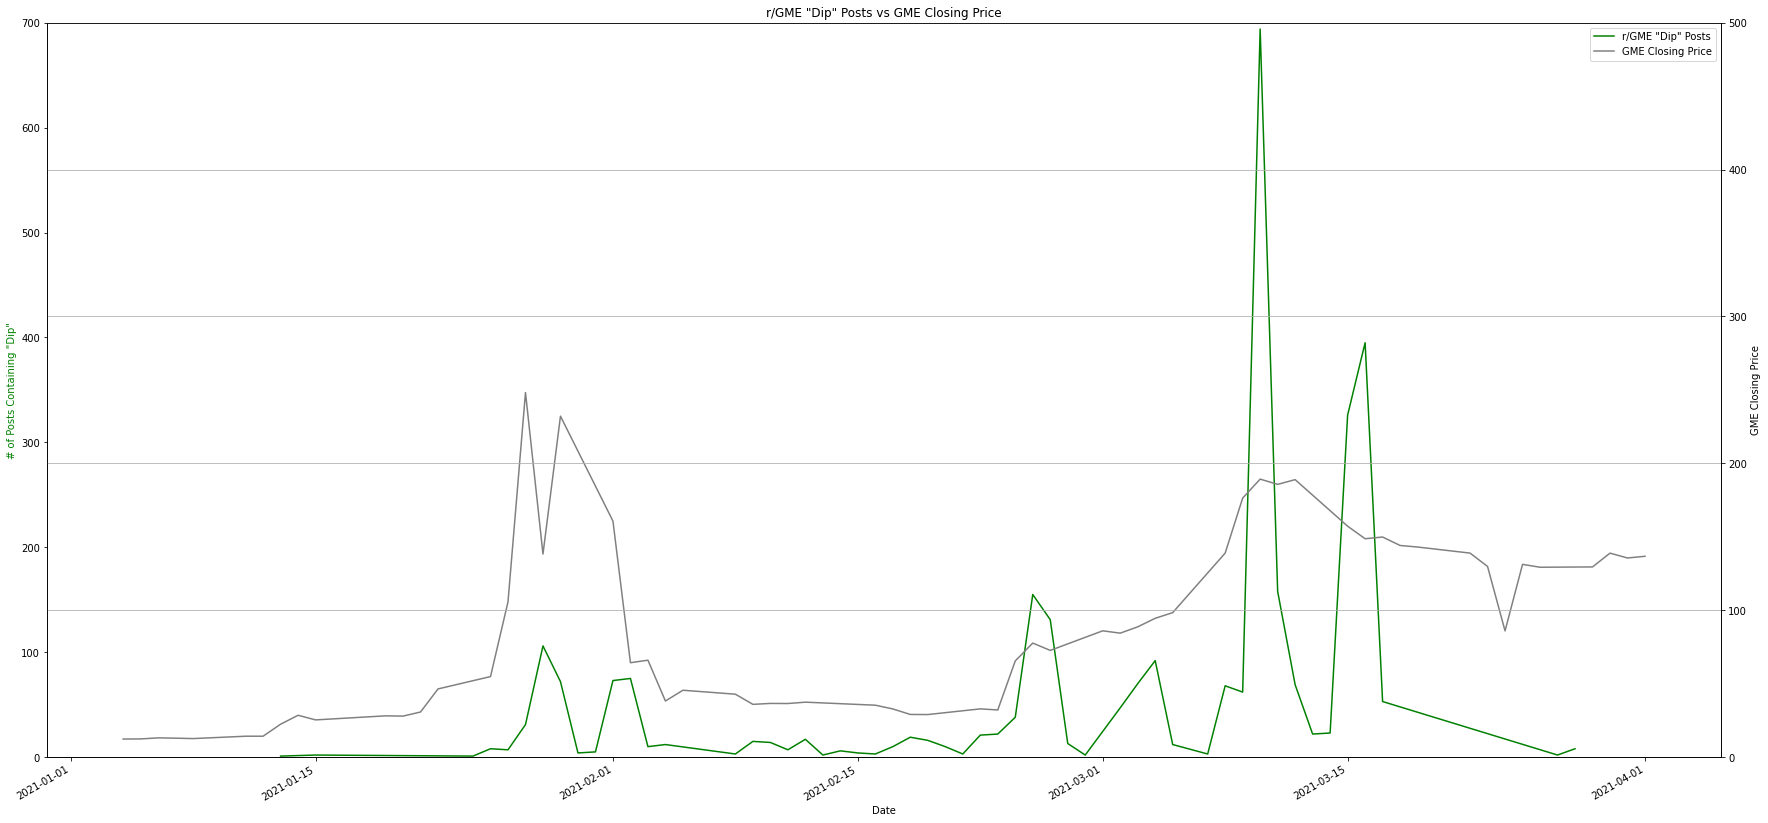

In [363]:
# Plotting GME posts with the word "Dip" in the title against the GME stock price.
ax = gmedaily_filtered_dip.plot(x='Date', y = 'Post ID', kind = 'line', figsize=(30,15), color = 'green', label = 'r/GME "Dip" Posts', title = 'r/GME "Dip" Posts vs GME Closing Price')
gmestock.plot(x='Date', y = 'Close', kind = 'line', figsize=(30,15), color = 'grey', label = 'GME Closing Price', ax=ax)

ax.set_ylabel('# of Posts Containing "Dip"', color='g')
ax2 = ax.twinx()
ax2.set_ylabel('GME Closing Price')
ax2.set_ylim(bottom=0, top=500)
ax.set_ylim(bottom=0, top=700)
plt.grid()

**Generating the Count(Buy) vs GME Close Price Graph**

In [364]:
# Filtering the gmedaily_filtered dataframe to only include titles with the word "Buy"

cols_list = ['Title'] # Target Columns
search_values = ['Buy'] # Target Word(s)

gme_filtered_buy = gme_filtered[gme_filtered[cols_list].stack().str.contains('|'.join(search_values),case=False,na=False).any(level=0)]

In [ ]:
gme_filtered_buy.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
67,kwtze7,BUY CALLS FOR JAN 15 or Stock,Do you think its still going up if I buy at st...,https://www.reddit.com/r/GME/comments/kwtze7/b...,SharpReaps,1,2021-01-14 00:23:28,6,/r/GME/comments/kwtze7/buy_calls_for_jan_15_or...,NaN,2021-01-14
75,kxdpvx,Should I buy more GME?,I bought 10 shares of GME when it was at $17 i...,https://www.reddit.com/r/GME/comments/kxdpvx/s...,jonastirona,1,2021-01-14 20:13:50,18,/r/GME/comments/kxdpvx/should_i_buy_more_gme/,NaN,2021-01-14
86,kxz3gu,Buy now 🚀🚀,Great time to buy right now ladies don’t be a ...,https://www.reddit.com/r/GME/comments/kxz3gu/b...,Pickle_rick57,5,2021-01-15 17:21:37,3,/r/GME/comments/kxz3gu/buy_now/,NaN,2021-01-15
89,ky1ues,Is next Wednesday too late to buy GME?,I just sold all my stocks and etfs except GME ...,https://www.reddit.com/r/GME/comments/ky1ues/i...,jonastirona,1,2021-01-15 19:29:28,17,/r/GME/comments/ky1ues/is_next_wednesday_too_l...,NaN,2021-01-15
118,l0jp3f,What buy price on opening?,[removed],https://www.reddit.com/r/GME/comments/l0jp3f/w...,DrySea3878,1,2021-01-19 13:21:03,0,/r/GME/comments/l0jp3f/what_buy_price_on_opening/,NaN,2021-01-19


In [365]:
gmedaily_filtered_buy = gme_filtered_buy.groupby('Date', as_index=False).count()

In [ ]:
gmedaily_filtered_buy.head()

,Date,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,2021-01-14,2,2,2,2,2,2,2,2,2,0
1,2021-01-15,2,2,2,2,2,2,2,2,2,0
2,2021-01-19,1,1,1,1,1,1,1,1,1,0
3,2021-01-21,2,2,1,2,2,2,2,2,2,0
4,2021-01-22,10,10,5,10,10,10,10,10,10,0


In [ ]:
gmestock.head()

,Date,Open,High,Low,Close,Volume
61,2021-01-04,19.00,19.10,17.15,17.25,"10,022,470"
60,2021-01-05,17.35,18.08,17.23,17.37,"4,961,457"
59,2021-01-06,17.34,18.98,17.33,18.36,"6,056,248"
58,2021-01-07,18.47,19.45,18.02,18.08,"6,129,276"
57,2021-01-08,18.18,18.30,17.08,17.69,"6,481,960"


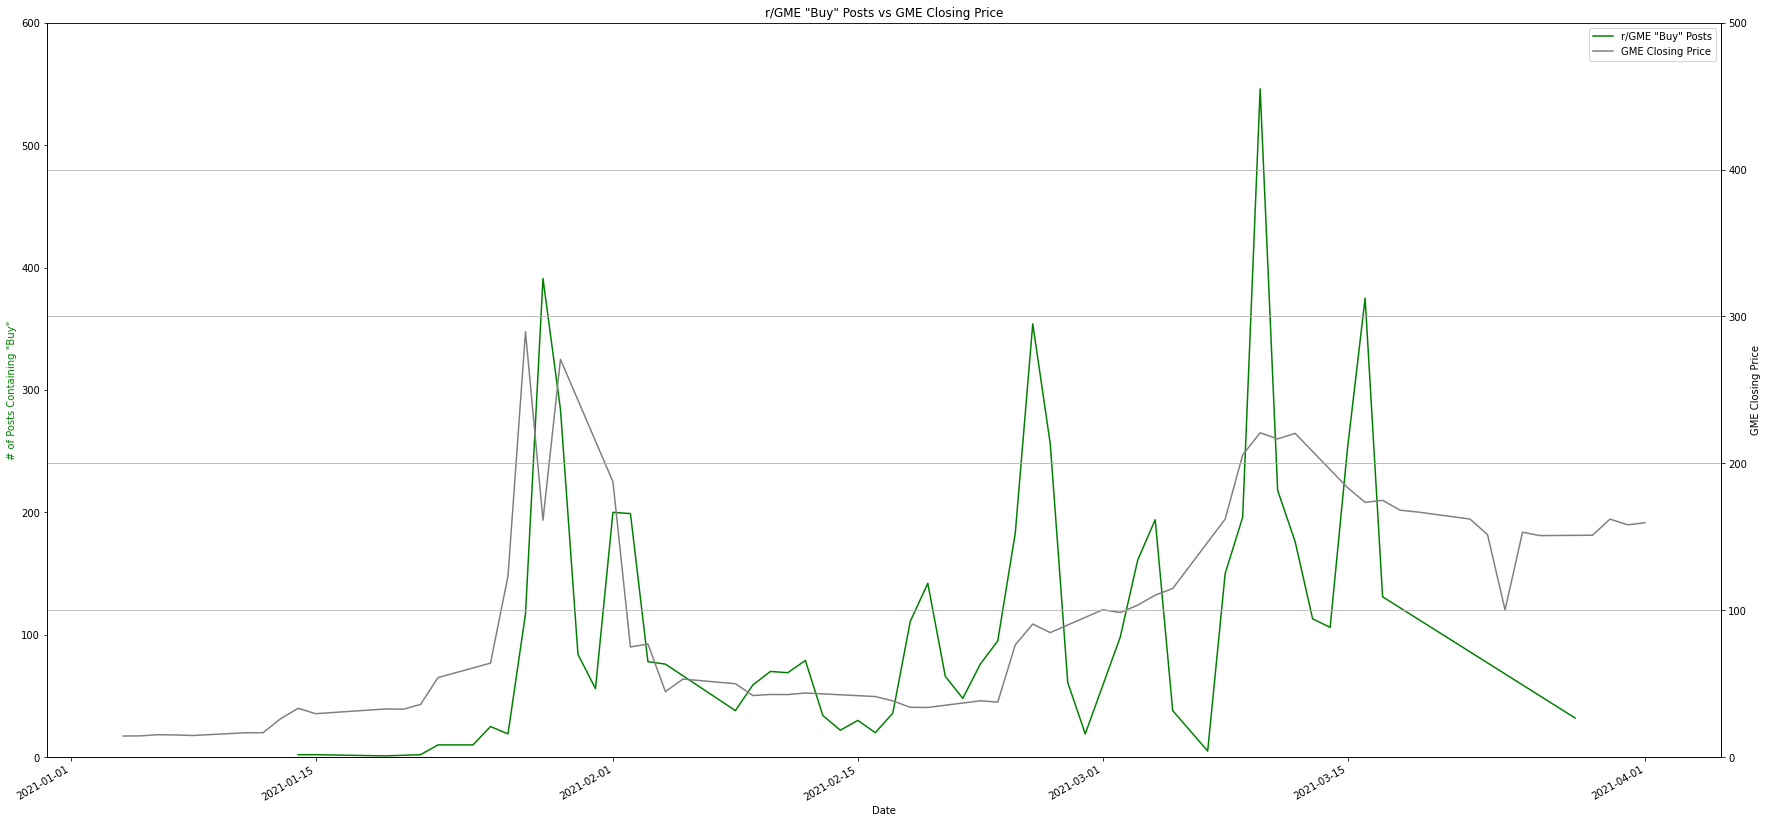

In [368]:
# Plotting GME posts with the word "Buy" in the title against the GME stock price.

ax = gmedaily_filtered_buy.plot(x='Date', y = 'Post ID', kind = 'line', figsize=(30,15), color = 'green', label = 'r/GME "Buy" Posts', title = 'r/GME "Buy" Posts vs GME Closing Price')
ax2 = gmestock.plot(x='Date', y = 'Close', kind = 'line', figsize=(30,15), color = 'grey', label = 'GME Closing Price', ax=ax)

ax.set_ylabel('# of Posts Containing "Buy"', color='g')
ax2 = ax.twinx()
ax2.set_ylabel('GME Closing Price')
ax2.set_ylim(bottom=0, top=500)
ax.set_ylim(bottom=0, top=600)
plt.grid()

**Generating the Count(Sell) vs GME Close Price Graph**

In [ ]:
# Filtering the gmedaily_filtered dataframe to only include titles with the word "Sell"

cols_list = ['Title'] # Target Columns
search_values = ['Sell'] # Target Word(s)

gme_filtered_sell = gme_filtered[gme_filtered[cols_list].stack().str.contains('|'.join(search_values),case=False,na=False).any(level=0)]

In [ ]:
gme_filtered_sell.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
69,kwvqbc,:) short squeeze not done yet bois don't sell 💎👐,NaN,https://i.redd.it/fw5ajyzdg7b61.jpg,jonastirona,2,2021-01-14 02:01:24,3,/r/GME/comments/kwvqbc/short_squeeze_not_done_...,NaN,2021-01-14
73,kx6g3k,GME IS A SELL,Cramer said GameStop (GME) is not doing too ...,https://www.reddit.com/r/GME/comments/kx6g3k/g...,Snafflepagus,1,2021-01-14 14:17:27,7,/r/GME/comments/kx6g3k/gme_is_a_sell/,NaN,2021-01-14
95,kym7ae,How much do you set your sell limit to?,What is the most optimistic price for sell lim...,https://www.reddit.com/r/GME/comments/kym7ae/h...,Ringsel1,1,2021-01-16 16:41:02,21,/r/GME/comments/kym7ae/how_much_do_you_set_you...,NaN,2021-01-16
111,l06jyc,Do I need to set a sell limit?,I realize that it’s good practice to set a sel...,https://www.reddit.com/r/GME/comments/l06jyc/d...,tweezy_0,1,2021-01-18 23:21:25,6,/r/GME/comments/l06jyc/do_i_need_to_set_a_sell...,NaN,2021-01-18
122,l0lnju,"What dickhole is selling 93,000 shares??",NaN,https://i.redd.it/u455lnbi1bc61.jpg,haventredditeither,2,2021-01-19 15:08:32,20,/r/GME/comments/l0lnju/what_dickhole_is_sellin...,NaN,2021-01-19


In [ ]:
gmedaily_filtered_sell = gme_filtered_sell.groupby('Date', as_index=False).count()

In [ ]:
gmedaily_filtered_sell.head()

,Date,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,2021-01-14,2,2,1,2,2,2,2,2,2,0
1,2021-01-16,1,1,1,1,1,1,1,1,1,0
2,2021-01-18,1,1,1,1,1,1,1,1,1,0
3,2021-01-19,1,1,0,1,1,1,1,1,1,0
4,2021-01-20,1,1,0,1,1,1,1,1,1,0


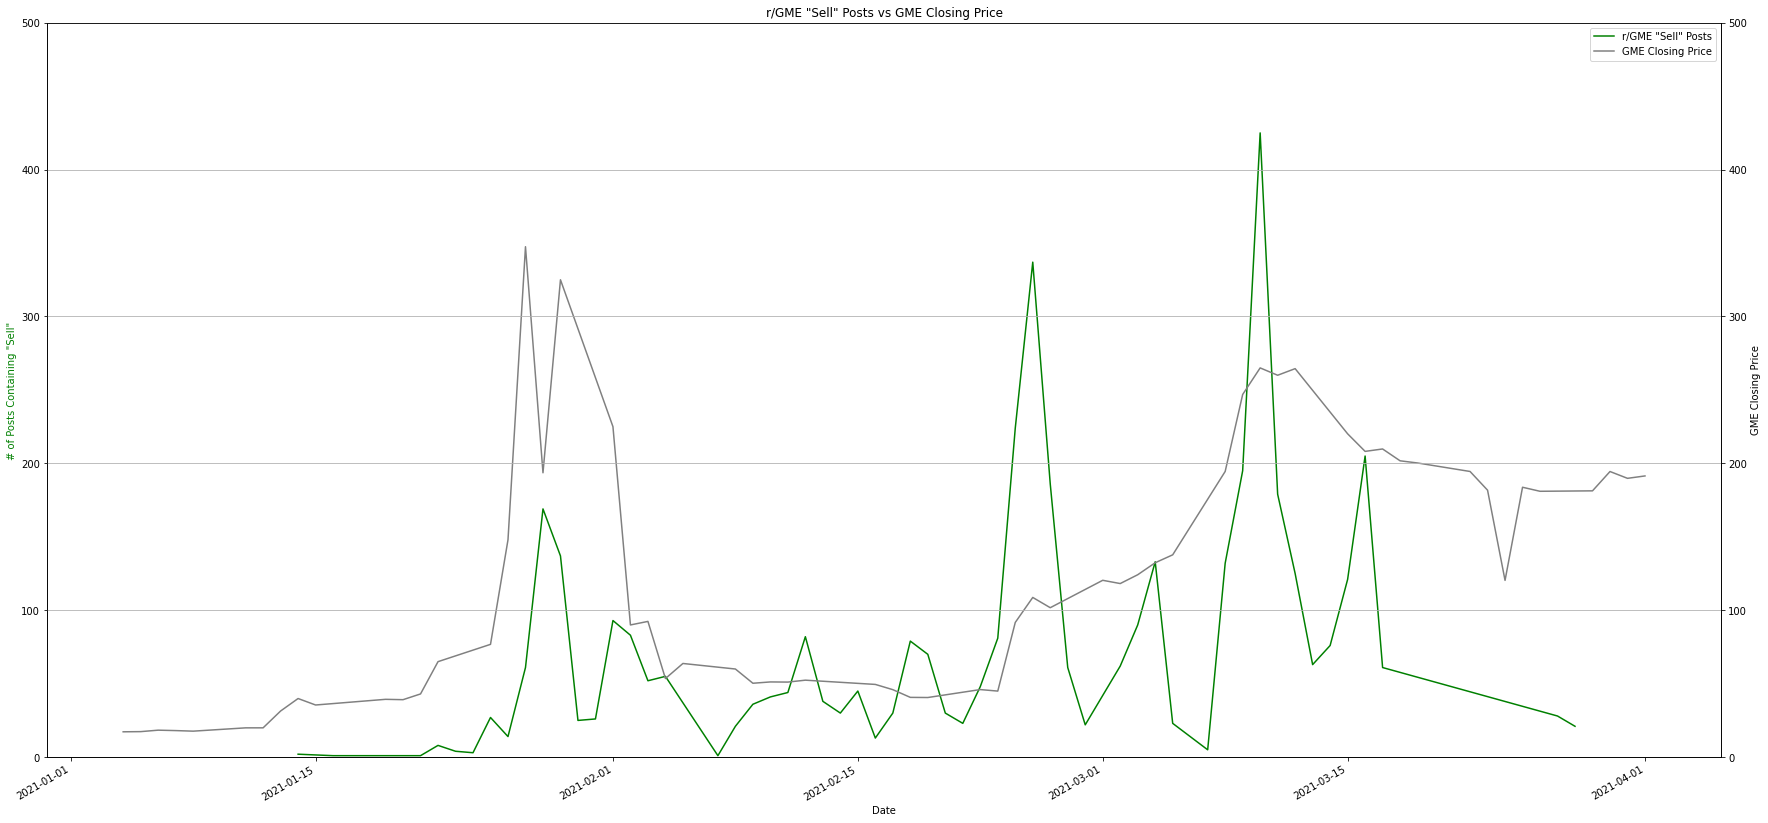

In [369]:
# Plotting GME posts with the word "Sell" in the title against the GME stock price.

ax = gmedaily_filtered_sell.plot(x='Date', y = 'Post ID', kind = 'line', figsize=(30,15), color = 'green', label = 'r/GME "Sell" Posts', title = 'r/GME "Sell" Posts vs GME Closing Price')
ax2 = gmestock.plot(x='Date', y = 'Close', kind = 'line', figsize=(30,15), color = 'grey', label = 'GME Closing Price', ax=ax)

ax.set_ylabel('# of Posts Containing "Sell"', color='g')
ax2 = ax.twinx()
ax2.set_ylabel('GME Closing Price')
ax2.set_ylim(bottom=0, top=500)
ax.set_ylim(bottom=0, top=500)
plt.grid()

**Generating the Count(Buy & Dip) vs GME Close Price Graph**

In [ ]:
# Filtering the gmedaily_filtered dataframe to only include titles with the word "Buy"

cols_list = ['Title'] # Target Columns
search_values = ['Buy', 'Dip'] # Target Word(s)

gme_filtered_comb = gme_filtered[gme_filtered[cols_list].stack().str.contains('|'.join(search_values),case=False,na=False).any(level=0)]

In [ ]:
gme_filtered_comb.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
65,kwlfc0,WTF is this dip to punish people who jump on l...,[deleted],https://v.redd.it/xwe3xfd6y4b61,[deleted],1,2021-01-13 17:36:13,0,/r/GME/comments/kwlfc0/wtf_is_this_dip_to_puni...,NaN,2021-01-13
67,kwtze7,BUY CALLS FOR JAN 15 or Stock,Do you think its still going up if I buy at st...,https://www.reddit.com/r/GME/comments/kwtze7/b...,SharpReaps,1,2021-01-14 00:23:28,6,/r/GME/comments/kwtze7/buy_calls_for_jan_15_or...,NaN,2021-01-14
75,kxdpvx,Should I buy more GME?,I bought 10 shares of GME when it was at $17 i...,https://www.reddit.com/r/GME/comments/kxdpvx/s...,jonastirona,1,2021-01-14 20:13:50,18,/r/GME/comments/kxdpvx/should_i_buy_more_gme/,NaN,2021-01-14
82,kxwgmq,GME Keep dipping and someone sold 810k shares,https://www.google.com/amp/s/seekingalpha.com/...,https://www.reddit.com/r/GME/comments/kxwgmq/g...,Snafflepagus,0,2021-01-15 15:13:52,13,/r/GME/comments/kxwgmq/gme_keep_dipping_and_so...,NaN,2021-01-15
83,kxwm8k,DIP BABY DIP. DIP! DIP! DIP!,GME should go down...... to the original price...,https://www.reddit.com/r/GME/comments/kxwm8k/d...,Snafflepagus,0,2021-01-15 15:22:03,7,/r/GME/comments/kxwm8k/dip_baby_dip_dip_dip_dip/,NaN,2021-01-15


In [ ]:
gmedaily_filtered_comb = gme_filtered_comb.groupby('Date', as_index=False).count()

In [ ]:
gmedaily_filtered_comb.head()

,Date,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,2021-01-13,1,1,1,1,1,1,1,1,1,0
1,2021-01-14,2,2,2,2,2,2,2,2,2,0
2,2021-01-15,4,4,4,4,4,4,4,4,4,0
3,2021-01-19,1,1,1,1,1,1,1,1,1,0
4,2021-01-21,2,2,1,2,2,2,2,2,2,0


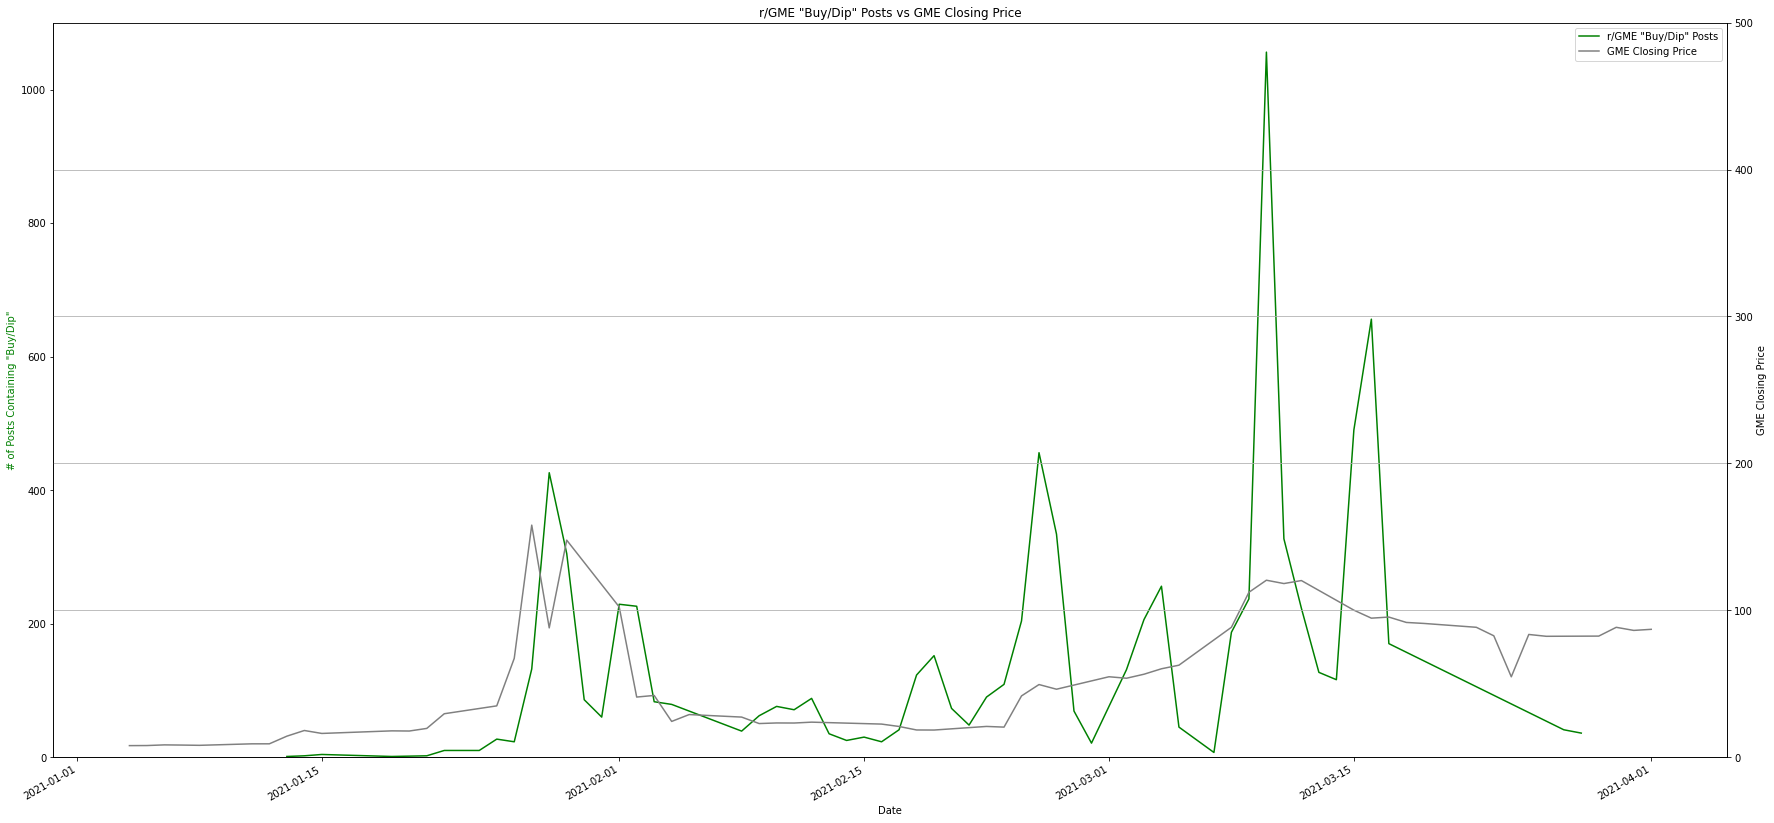

In [370]:
# Plotting GME posts with "Buy/Dip" in the title against the GME stock price.

ax = gmedaily_filtered_comb.plot(x='Date', y = 'Post ID', kind = 'line', figsize=(30,15), color = 'green', label = 'r/GME "Buy/Dip" Posts', title = 'r/GME "Buy/Dip" Posts vs GME Closing Price')
ax2 = gmestock.plot(x='Date', y = 'Close', kind = 'line', figsize=(30,15), color = 'grey', label = 'GME Closing Price', ax=ax)

ax.set_ylabel('# of Posts Containing "Buy/Dip"', color='g')
ax2 = ax.twinx()
ax2.set_ylabel('GME Closing Price')
ax2.set_ylim(bottom=0, top=500)
ax.set_ylim(bottom=0, top=1100)
plt.grid()

**Generating the Count(Buy, Sell & Dip) vs GME Close Price Graph**

In [ ]:
# Filtering the gmedaily_filtered dataframe to only include titles with the word "Buy"

cols_list = ['Title'] # Target Columns
search_values = ['Buy', 'Dip', 'Sell'] # Target Word(s)

gme_filtered_comb2 = gme_filtered[gme_filtered[cols_list].stack().str.contains('|'.join(search_values),case=False,na=False).any(level=0)]

In [ ]:
gme_filtered_comb2.head()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Date
65,kwlfc0,WTF is this dip to punish people who jump on l...,[deleted],https://v.redd.it/xwe3xfd6y4b61,[deleted],1,2021-01-13 17:36:13,0,/r/GME/comments/kwlfc0/wtf_is_this_dip_to_puni...,NaN,2021-01-13
67,kwtze7,BUY CALLS FOR JAN 15 or Stock,Do you think its still going up if I buy at st...,https://www.reddit.com/r/GME/comments/kwtze7/b...,SharpReaps,1,2021-01-14 00:23:28,6,/r/GME/comments/kwtze7/buy_calls_for_jan_15_or...,NaN,2021-01-14
69,kwvqbc,:) short squeeze not done yet bois don't sell 💎👐,NaN,https://i.redd.it/fw5ajyzdg7b61.jpg,jonastirona,2,2021-01-14 02:01:24,3,/r/GME/comments/kwvqbc/short_squeeze_not_done_...,NaN,2021-01-14
73,kx6g3k,GME IS A SELL,Cramer said GameStop (GME) is not doing too ...,https://www.reddit.com/r/GME/comments/kx6g3k/g...,Snafflepagus,1,2021-01-14 14:17:27,7,/r/GME/comments/kx6g3k/gme_is_a_sell/,NaN,2021-01-14
75,kxdpvx,Should I buy more GME?,I bought 10 shares of GME when it was at $17 i...,https://www.reddit.com/r/GME/comments/kxdpvx/s...,jonastirona,1,2021-01-14 20:13:50,18,/r/GME/comments/kxdpvx/should_i_buy_more_gme/,NaN,2021-01-14


In [ ]:
gmedaily_filtered_comb2 = gme_filtered_comb2.groupby('Date', as_index=False).count()

In [ ]:
gmedaily_filtered_comb2.head()

,Date,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,2021-01-13,1,1,1,1,1,1,1,1,1,0
1,2021-01-14,4,4,3,4,4,4,4,4,4,0
2,2021-01-15,4,4,4,4,4,4,4,4,4,0
3,2021-01-16,1,1,1,1,1,1,1,1,1,0
4,2021-01-18,1,1,1,1,1,1,1,1,1,0


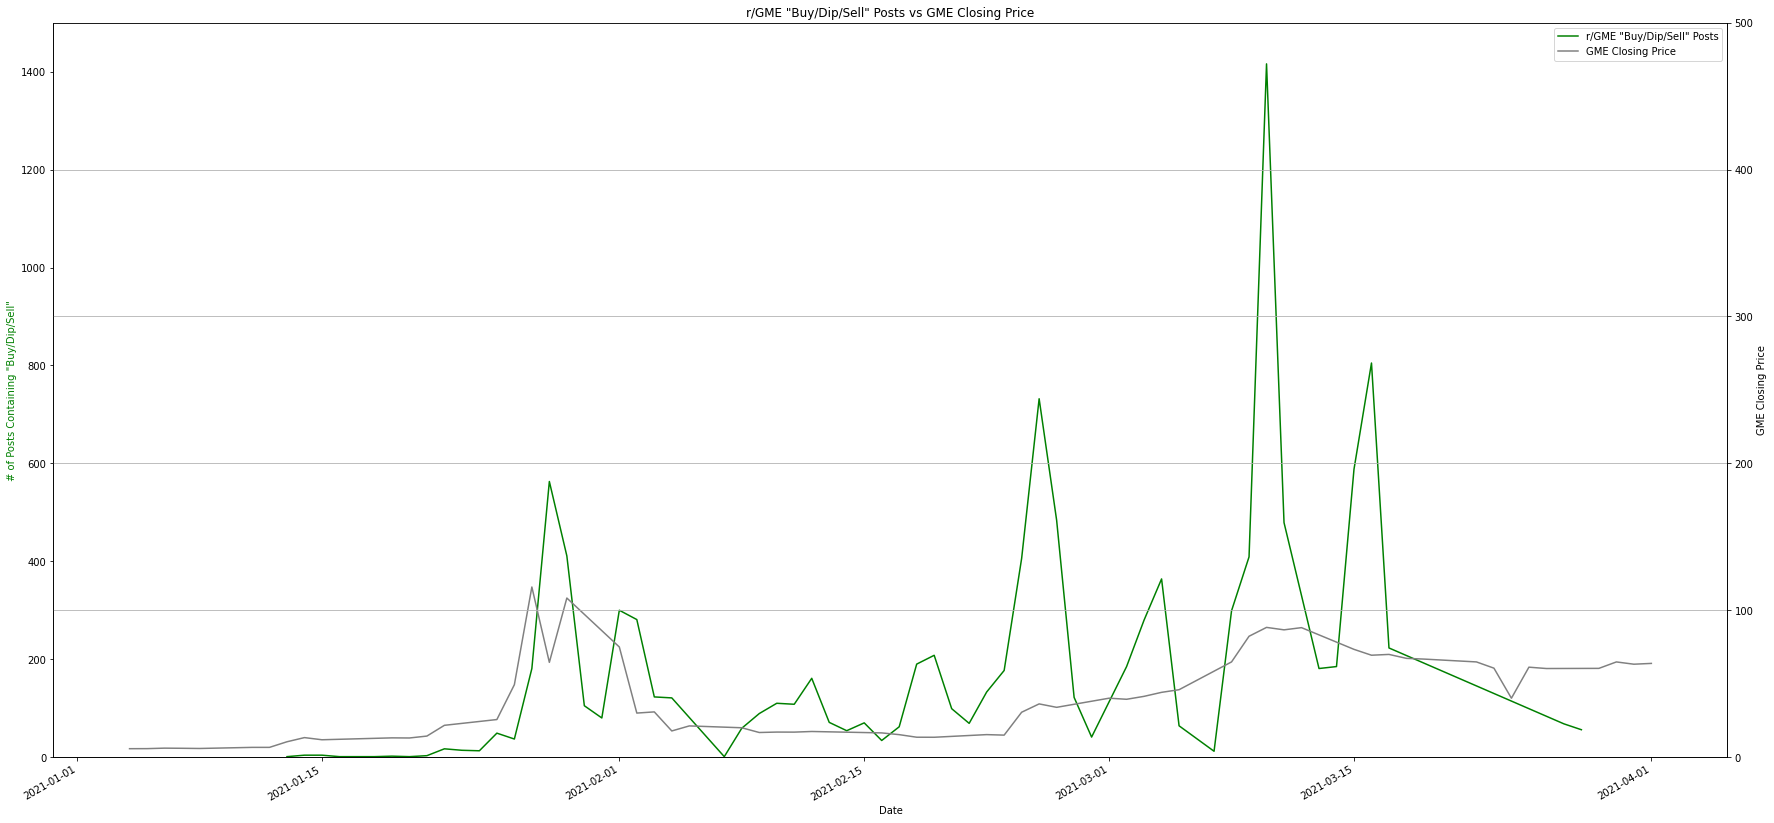

In [371]:
# Plotting GME posts with "Buy/Dip/Sell" in the title against the GME stock price.

ax = gmedaily_filtered_comb2.plot(x='Date', y = 'Post ID', kind = 'line', figsize=(30,15), color = 'green', label = 'r/GME "Buy/Dip/Sell" Posts', title = 'r/GME "Buy/Dip/Sell" Posts vs GME Closing Price')
ax2 = gmestock.plot(x='Date', y = 'Close', kind = 'line', figsize=(30,15), color = 'grey', label = 'GME Closing Price', ax=ax)

ax.set_ylabel('# of Posts Containing "Buy/Dip/Sell"', color='g')
ax2 = ax.twinx()
ax2.set_ylabel('GME Closing Price')
ax2.set_ylim(bottom=0, top=500)
ax.set_ylim(bottom=0, top=1500)
plt.grid()

**Predictive Modeling Time (Hopefully)**

Time Lagged Cross Correlation

To be explored later, few actionable insights garnered

In [ ]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
datax = gmedaily_filtered['Post ID']
datay = gmestock['Close']

xcov_monthly = [crosscorr(datax, datay, lag=i) for i in range(12)]

In [ ]:
xcov_monthly

[-0.4452456654811347,
 -0.4642139305573305,
 -0.4359981425468699,
 -0.4179747904139276,
 -0.4533099826423808,
 -0.42118154815991954,
 -0.49459251577180213,
 -0.5444201855106502,
 -0.5228018711801343,
 -0.47294150685930353,
 -0.42151548175185594,
 -0.3781687014842847]

In [ ]:
gmedaily_filtered['Post ID'].corr(gmestock['Close'])

-0.4452456654811347

In [ ]:
gmedaily_filtered_comb2['Post ID'].corr(gmestock['Close'])

-0.22744691796355537

In [ ]:
gmedaily_filtered.set_index(['Date'],inplace=True)
gmestock.set_index(['Date'],inplace=True)

In [ ]:
combined = pd.concat([gmedaily_filtered,gmestock],axis=1)

In [ ]:
combined

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Open,High,Low,Close,Volume
Date,,,,,,,,,,,,,,,
2021-01-04,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,19.00,19.10,17.15,17.25,"10,022,470"
2021-01-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,17.35,18.08,17.23,17.37,"4,961,457"
2021-01-06,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,17.34,18.98,17.33,18.36,"6,056,248"
2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.47,19.45,18.02,18.08,"6,129,276"
2021-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.18,18.30,17.08,17.69,"6,481,960"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-28,731.0,731.0,436.0,731.0,731.0,731.0,731.0,731.0,731.0,723.0,NaN,NaN,NaN,NaN,NaN
2021-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.75,193.92,173.51,181.30,"10,042,180"
2021-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.50,204.30,182.00,194.46,"17,094,920"


In [ ]:
combined.drop(combined.tail(4).index,
        inplace = True)

In [ ]:
combined.tail()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Open,High,Low,Close,Volume
Date,,,,,,,,,,,,,,,
2021-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.98,166.97,118.62,120.34,"24,177,881"
2021-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.49,187.50,116.90,183.75,"50,962,340"
2021-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.68,218.93,163.26,181.00,"37,430,672"
2021-03-27,788.0,788.0,454.0,788.0,788.0,788.0,788.0,788.0,788.0,775.0,NaN,NaN,NaN,NaN,NaN
2021-03-28,731.0,731.0,436.0,731.0,731.0,731.0,731.0,731.0,731.0,723.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
gmedaily_filtered.tail()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
Date,,,,,,,,,,
2021-03-15,3825,3825,2323,3825,3825,3825,3825,3825,3825,3775
2021-03-16,4926,4926,2852,4926,4926,4926,4926,4926,4926,4874
2021-03-17,2530,2530,1404,2530,2530,2530,2530,2530,2530,2496
2021-03-27,788,788,454,788,788,788,788,788,788,775
2021-03-28,731,731,436,731,731,731,731,731,731,723


In [ ]:
gmedaily.tail()

,Post ID,Title,selftext,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
Date,,,,,,,,,,
2021/03/15,3825,3825,2323,3825,3825,3825,3825,3825,3825,3775
2021/03/16,4926,4926,2852,4926,4926,4926,4926,4926,4926,4874
2021/03/17,2530,2530,1404,2530,2530,2530,2530,2530,2530,2496
2021/03/27,788,788,454,788,788,788,788,788,788,775
2021/03/28,731,731,436,731,731,731,731,731,731,723
